## New data process logic

This notebook describes how to import our trained model and use it to generate a category mask on a new image.

In [241]:
from keras.models import load_model
from keras import backend
from pathlib import Path

Load model:

In [242]:
def iou_evaluate(y_true, y_pred):
    y_true_flat = backend.flatten(y_true)
    y_pred_flat = backend.flatten(y_pred)

    inter = backend.sum(y_true_flat * y_pred_flat)
    union = backend.sum(y_true_flat) + backend.sum(y_pred_flat) - inter

    return (inter + 1.0) / (union + 1.0)

In [243]:
model_path = Path(".") / "aerial_images_segmentation_v7.h5"

unet = load_model(model_path, custom_objects={'iou_evaluate': iou_evaluate})

Load image:

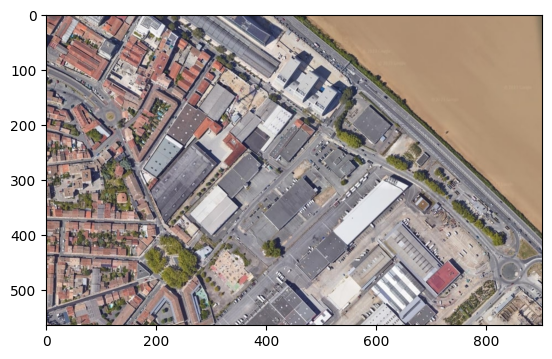

In [244]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

new_image_path = Path(".") / "Bordeaux.jpg"

Img = Image.open(new_image_path)

if (Img.mode != 'RGB'):
    Img = Img.convert('RGB')

new_image = np.array(Img)

plt.imshow(new_image)

Patchify image:

In [245]:
from patchify import patchify

patch_size = 256

assert (new_image.shape[0] >= patch_size and new_image.shape[1] >= patch_size), "Image too small."

patches = patchify(new_image, patch_size=(patch_size, patch_size, 3), step=patch_size)

patches = np.reshape(patches, (patches.shape[0] * patches.shape[1] * patches.shape[2], patch_size, patch_size, 3))

print(patches.shape)

(6, 256, 256, 3)


Normalize image:

In [246]:
normalized_images = np.array([(image / 255.0) for image in patches])

print(normalized_images.shape)

(6, 256, 256, 3)


Predict:

In [247]:
ouput_labels = unet.predict(normalized_images)

1/1 [==============================] - 0s 426ms/step


Decode labels:

In [248]:
classes = dict() # {key: (index, hex_color)

classes['Water'] = dict({'index': 0, 'color': 'E2A929'})
classes['Land'] = dict({'index': 1, 'color': '8429F6'})
classes['Road'] = dict({'index': 2, 'color': '6EC1E4'})
classes['Building'] = dict({'index': 3, 'color': '3C1098'})
classes['Vegetation'] = dict({'index': 4, 'color': 'FEDD3A'})
classes['Unlabeled'] = dict({'index': 5, 'color': '9B9B9B'})

# Convert hex to RGB:
for key in classes:
    color = classes[key]['color']
    color = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
    classes[key]['color'] = color

print(classes)

convert_table = [None] * len(classes)
for key in classes:
    convert_table[classes[key]['index']] = classes[key]['color']

print(convert_table)

def cat_to_rgb(label: np.array) -> np.array:

    mask_shape = (label.shape[0], label.shape[1], 3)
    mask = np.zeros(shape=mask_shape, dtype=np.uint8)

    for i in range(mask_shape[0]):
        for j in range(mask_shape[1]):
            index = label[i, j]
            mask[i, j] = convert_table[index]

    return mask

{'Water': {'index': 0, 'color': (226, 169, 41)}, 'Land': {'index': 1, 'color': (132, 41, 246)}, 'Road': {'index': 2, 'color': (110, 193, 228)}, 'Building': {'index': 3, 'color': (60, 16, 152)}, 'Vegetation': {'index': 4, 'color': (254, 221, 58)}, 'Unlabeled': {'index': 5, 'color': (155, 155, 155)}}
[(226, 169, 41), (132, 41, 246), (110, 193, 228), (60, 16, 152), (254, 221, 58), (155, 155, 155)]


In [249]:
ouput_labels = np.argmax(ouput_labels, axis=3)

masks = np.array([cat_to_rgb(label) for label in ouput_labels])

print(masks.shape)

(6, 256, 256, 3)


Show the result:

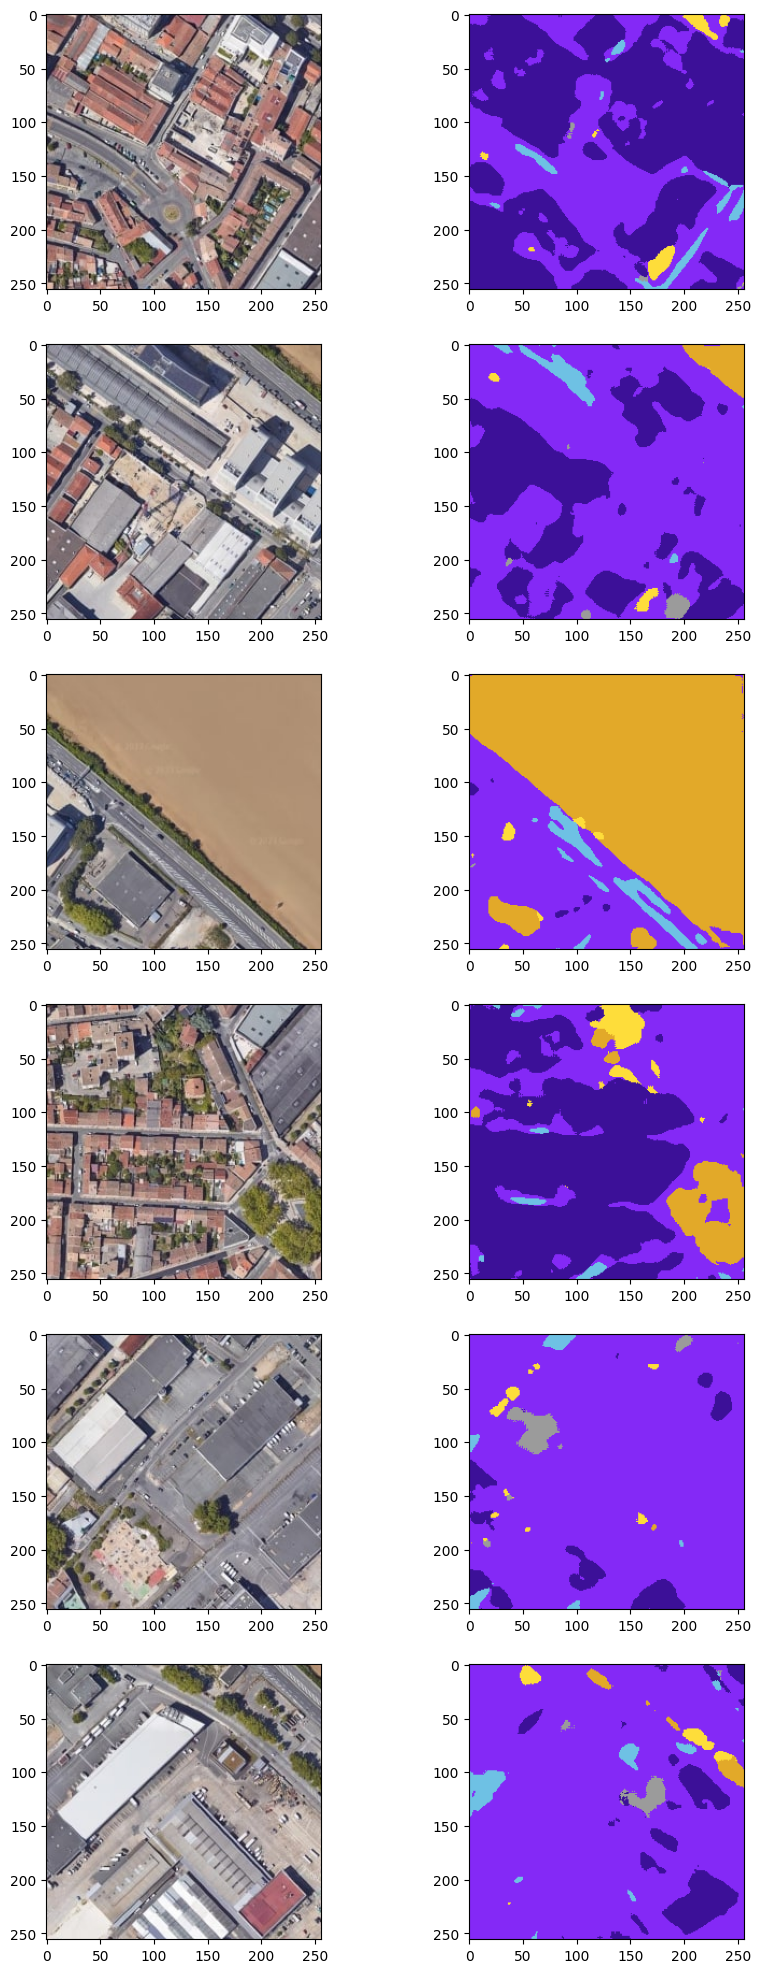

In [250]:
fig, ax = plt.subplots(masks.shape[0], 2, figsize=(10, 25))

for i in range(masks.shape[0]):
	ax[i, 0].imshow(patches[i])
	ax[i, 1].imshow(masks[i])